In [33]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Data used for training and testing
tickers = ['AAPL', 'GOOG', 'AMZN', 'MSFT']
stock = yf.download(tickers, start="2010-01-01", end="2020-01-01").stack()
stock.index.names = ['date', 'ticker']
stock.columns = stock.columns.str.lower()

# Data used purely for backtesting.
backtest_stocks = yf.download(tickers, start="2020-01-01", end="2025-01-01").stack()
backtest_stocks.index.names = ['date', 'ticker']
backtest_stocks.columns = stock.columns.str.lower()

backtest_stocks


[*********************100%***********************]  4 of 4 completed


ValueError: Length of names must match number of levels in MultiIndex.

In [58]:
''' Adding only three features due the size of the dataset I am uisng. However, For this dataset using just SMA and RSI can be sufficient. '''

# Calculating the Garman-Klass Volatility to capture volatility.
stock['gk_volatility'] = np.sqrt((np.log(stock['high'] / stock['low']) ** 2) / 2 - (2 * np.log(2) - 1) * (np.log(stock['close'] / stock['open']) ** 2))

# Calculating Relative Strength Index (RSI) to capture momentum.
delta = stock['close'].diff() # delta is the day-to-day difference between closing prices
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss # Relative Strength
stock['rsi'] = 100 - (100 / (1 + rs))

# Bollinger Bands to capture price extremes.
window = 20
stock['bb_middle'] = stock['close'].rolling(window=window).mean()
stock['bb_Upper'] = stock['bb_middle'] + (2 * stock['close'].rolling(window=window).std())
stock['bb_Lower'] = stock['bb_middle'] - (2 * stock['close'].rolling(window=window).std())

stock = stock.dropna()
stock

Price                   close        high         low        open     volume  \
date       ticker                                                              
2010-01-08 MSFT     23.082354   23.247980   22.766157   22.796272   51197400   
2010-01-11 AAPL      6.322965    6.409935    6.273009    6.403916  462229600   
           AMZN      6.515500    6.640000    6.460500    6.631000  175588000   
           GOOG     14.918032   15.001170   14.742572   15.001170  289597429   
           MSFT     22.788736   23.157632   22.675809   23.119989   68754700   
...                       ...         ...         ...         ...        ...   
2019-12-30 MSFT    150.732529  152.100310  149.909951  152.071617   16348400   
2019-12-31 AAPL     71.093964   71.101226   70.094071   70.193335  100805600   
           AMZN     92.391998   92.663002   91.611504   92.099998   50130000   
           GOOG     66.611656   66.660484   66.216325   66.267396   19236000   
           MSFT    150.837738  150.904699  149.642131  149.948214   18369400   

Price              gk_volatility        rsi  bb_middle    bb_Upper   bb_Lower  
date       ticker                                                              
2010-01-08 MSFT         0.012618  56.985503  12.838801   27.052607  -1.375005  
2010-01-11 AAPL         0.013062  46.335453  12.832932   27.057954  -1.392089  
           AMZN         0.016008  42.847527  12.823957   27.065501  -1.417586  
           GOOG         0.011801  53.936810  12.792141   27.010827  -1.426544  
           MSFT         0.011857  56.946099  12.766544   26.907204  -1.374115  
...                          ...        ...        ...         ...        ...  
2019-12-30 MSFT         0.008659  54.094117  94.918039  164.353469  25.482609  
2019-12-31 AAPL         0.006243  50.258035  95.034855  164.292607  25.777102  
           AMZN         0.007826  46.088098  95.171954  164.395672  25.948237  
           GOOG         0.003461  49.740262  95.142510  164.416806  25.868215  
           MSFT         0.004667  53.829035  95.156377  164.477477  25.835278  

[10045 rows x 10 columns]

In [59]:
# prepping data.
stock['return'] = stock['close'].pct_change()
stock['signal'] = (stock['return'].shift(-1) > 0).astype(int) # Target => 1(if next day's return is _+ve):buy and 0:sell
stock = stock.dropna()

stock

Price                   close        high         low        open     volume  \
date       ticker                                                              
2010-01-11 AAPL      6.322965    6.409935    6.273009    6.403916  462229600   
           AMZN      6.515500    6.640000    6.460500    6.631000  175588000   
           GOOG     14.918032   15.001170   14.742572   15.001170  289597429   
           MSFT     22.788736   23.157632   22.675809   23.119989   68754700   
2010-01-12 AAPL      6.251043    6.312735    6.211921    6.295280  594459600   
...                       ...         ...         ...         ...        ...   
2019-12-30 MSFT    150.732529  152.100310  149.909951  152.071617   16348400   
2019-12-31 AAPL     71.093964   71.101226   70.094071   70.193335  100805600   
           AMZN     92.391998   92.663002   91.611504   92.099998   50130000   
           GOOG     66.611656   66.660484   66.216325   66.267396   19236000   
           MSFT    150.837738  150.904699  149.642131  149.948214   18369400   

Price              gk_volatility        rsi  bb_middle    bb_Upper   bb_Lower  \
date       ticker                                                               
2010-01-11 AAPL         0.013062  46.335453  12.832932   27.057954  -1.392089   
           AMZN         0.016008  42.847527  12.823957   27.065501  -1.417586   
           GOOG         0.011801  53.936810  12.792141   27.010827  -1.426544   
           MSFT         0.011857  56.946099  12.766544   26.907204  -1.374115   
2010-01-12 AAPL         0.010506  46.447901  12.756523   26.916297  -1.403251   
...                          ...        ...        ...         ...        ...   
2019-12-30 MSFT         0.008659  54.094117  94.918039  164.353469  25.482609   
2019-12-31 AAPL         0.006243  50.258035  95.034855  164.292607  25.777102   
           AMZN         0.007826  46.088098  95.171954  164.395672  25.948237   
           GOOG         0.003461  49.740262  95.142510  164.416806  25.868215   
           MSFT         0.004667  53.829035  95.156377  164.477477  25.835278   

Price                return  signal  
date       ticker                    
2010-01-11 AAPL   -0.726069       1  
           AMZN    0.030450       1  
           GOOG    1.289622       1  
           MSFT    0.527597       0  
2010-01-12 AAPL   -0.725696       1  
...                     ...     ...  
2019-12-30 MSFT    1.264346       0  
2019-12-31 AAPL   -0.528344       1  
           AMZN    0.299576       0  
           GOOG   -0.279032       1  
           MSFT    1.264435       0  

[10044 rows x 12 columns]

In [60]:
# defining Feature list and Target. 
X = stock[['gk_volatility', 'rsi', 'bb_middle', 'bb_Upper', 'bb_Lower']]
y = stock['signal']

# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [61]:
# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [62]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.9193628670980587


In [63]:
''' Apply model to backtesting data: Adding idential features to generate predictions on unseen data.'''


features = ['gk_volatility', 'rsi', 'bb_middle', 'bb_Upper', 'bb_Lower']

# Calculating the Garman-Klass Volatility to capture volatility.
backtest_stocks['gk_volatility'] = np.sqrt((np.log(backtest_stocks['high'] / backtest_stocks['low']) ** 2) / 2 - (2 * np.log(2) - 1) * (np.log(backtest_stocks['close'] / backtest_stocks['open']) ** 2))

# Calculating Relative Strength Index (RSI) to capture momentum.
delta = backtest_stocks['close'].diff() # delta is the day-to-day difference between closing prices
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss # Relative Strength
backtest_stocks['rsi'] = 100 - (100 / (1 + rs))

# Bollinger Bands to capture price extremes.
window = 20
backtest_stocks['bb_middle'] = backtest_stocks['close'].rolling(window=window).mean()
backtest_stocks['bb_Upper'] = backtest_stocks['bb_middle'] + (2 * backtest_stocks['close'].rolling(window=window).std())
backtest_stocks['bb_Lower'] = backtest_stocks['bb_middle'] - (2 * backtest_stocks['close'].rolling(window=window).std())

backtest_stocks = backtest_stocks.dropna()
backtest_stocks['Predicted_Signal'] = model.predict(backtest_stocks[features])
backtest_stocks['return'] = backtest_stocks['close'].pct_change()

backtest_stocks

C:\Users\harsi\AppData\Local\Temp\ipykernel_36936\734503420.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['Predicted_Signal'] = model.predict(backtest_stocks[features])
C:\Users\harsi\AppData\Local\Temp\ipykernel_36936\734503420.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['return'] = backtest_stocks['close'].pct_change()


Price                   close        high         low        open     volume  \
date       ticker                                                              
2020-01-08 MSFT    153.123749  153.802860  151.076871  152.014222   27746500   
2020-01-09 AAPL     74.962807   75.156487   74.132390   74.384173  170108400   
           AMZN     95.052498   95.890999   94.790001   95.494499   63346000   
           GOOG     70.737328   71.110985   70.261035   70.774198   30018000   
           MSFT    155.036758  155.161106  154.022886  154.797637   21385000   
...                       ...         ...         ...         ...        ...   
2024-12-30 MSFT    424.829987  427.549988  421.899994  426.059998   13158700   
2024-12-31 AAPL    250.144974  253.001833  249.156056  252.162760   39480700   
           AMZN    219.389999  223.229996  218.940002  222.970001   24819700   
           GOOG    190.440002  193.250000  189.580002  192.445007   14355200   
           MSFT    421.500000  426.730011  420.660004  426.100006   13246500   

Price              gk_volatility        rsi   bb_middle    bb_Upper  \
date       ticker                                                     
2020-01-08 MSFT         0.011810  54.031326   97.137456  165.529786   
2020-01-09 AAPL         0.008422  50.454803   97.249792  165.480415   
           AMZN         0.007640  46.090900   97.257392  165.486947   
           GOOG         0.008496  49.862263   97.388073  165.392321   
           MSFT         0.005117  54.092684   97.458378  165.709909   
...                          ...        ...         ...         ...   
2024-12-30 MSFT         0.009233  55.734555  277.526195  467.666323   
2024-12-31 AAPL         0.009611  51.420772  277.283961  467.557274   
           AMZN         0.009331  43.291322  277.000461  467.617987   
           GOOG         0.011893  47.704469  276.722961  467.852526   
           MSFT         0.007557  55.763360  276.035461  464.848954   

Price               bb_Lower  Predicted_Signal    return  
date       ticker                                         
2020-01-08 MSFT    28.745126                 0       NaN  
2020-01-09 AAPL    29.019169                 1 -0.510443  
           AMZN    29.027837                 0  0.267995  
           GOOG    29.383824                 1 -0.255808  
           MSFT    29.206847                 0  1.191725  
...                      ...               ...       ...  
2024-12-30 MSFT    87.386067                 0  1.204733  
2024-12-31 AAPL    87.010647                 1 -0.411188  
           AMZN    86.382934                 0 -0.122949  
           GOOG    85.593395                 0 -0.131957  
           MSFT    87.221968                 0  1.213295  

[5013 rows x 12 columns]

In [64]:
# Comparission and plotting 
# Convert the index to datetime if not already
#backtest_stocks.index = pd.to_datetime(backtest_stocks.index)

# calculating the returns from the model: if signal = 1 we take the return(loss or gain) for the day, else we do nothing. 
# shifting by one to ensure that only past predictions affect the future.
backtest_stocks['strategy_return'] = backtest_stocks['Predicted_Signal'].shift(1) * backtest_stocks['return']

# This represents the compunded growth of investing 1 dollar, following the models's predictions.
backtest_stocks['Cumulative_Strategy_Return'] = (1 + backtest_stocks['strategy_return']).cumprod()

# This represents the compunded growth of investing 1 dollar, following the buy-hold statergy.
backtest_stocks['Cumulative_Stock_Return'] = (1 + backtest_stocks['return']).cumprod()
backtest_stocks




C:\Users\harsi\AppData\Local\Temp\ipykernel_36936\2916122683.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['strategy_return'] = backtest_stocks['Predicted_Signal'].shift(1) * backtest_stocks['return']
C:\Users\harsi\AppData\Local\Temp\ipykernel_36936\2916122683.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_stocks['Cumulative_Strategy_Return'] = (1 + backtest_stocks['strategy_return']).cumprod()
C:\Users\harsi\AppData\Local\Temp\ipykernel_36936\2916122683.py:13: SettingW

Price                   close        high         low        open     volume  \
date       ticker                                                              
2020-01-08 MSFT    153.123749  153.802860  151.076871  152.014222   27746500   
2020-01-09 AAPL     74.962807   75.156487   74.132390   74.384173  170108400   
           AMZN     95.052498   95.890999   94.790001   95.494499   63346000   
           GOOG     70.737328   71.110985   70.261035   70.774198   30018000   
           MSFT    155.036758  155.161106  154.022886  154.797637   21385000   
...                       ...         ...         ...         ...        ...   
2024-12-30 MSFT    424.829987  427.549988  421.899994  426.059998   13158700   
2024-12-31 AAPL    250.144974  253.001833  249.156056  252.162760   39480700   
           AMZN    219.389999  223.229996  218.940002  222.970001   24819700   
           GOOG    190.440002  193.250000  189.580002  192.445007   14355200   
           MSFT    421.500000  426.730011  420.660004  426.100006   13246500   

Price              gk_volatility        rsi   bb_middle    bb_Upper  \
date       ticker                                                     
2020-01-08 MSFT         0.011810  54.031326   97.137456  165.529786   
2020-01-09 AAPL         0.008422  50.454803   97.249792  165.480415   
           AMZN         0.007640  46.090900   97.257392  165.486947   
           GOOG         0.008496  49.862263   97.388073  165.392321   
           MSFT         0.005117  54.092684   97.458378  165.709909   
...                          ...        ...         ...         ...   
2024-12-30 MSFT         0.009233  55.734555  277.526195  467.666323   
2024-12-31 AAPL         0.009611  51.420772  277.283961  467.557274   
           AMZN         0.009331  43.291322  277.000461  467.617987   
           GOOG         0.011893  47.704469  276.722961  467.852526   
           MSFT         0.007557  55.763360  276.035461  464.848954   

Price               bb_Lower  Predicted_Signal    return  strategy_return  \
date       ticker                                                           
2020-01-08 MSFT    28.745126                 0       NaN              NaN   
2020-01-09 AAPL    29.019169                 1 -0.510443        -0.000000   
           AMZN    29.027837                 0  0.267995         0.267995   
           GOOG    29.383824                 1 -0.255808        -0.000000   
           MSFT    29.206847                 0  1.191725         1.191725   
...                      ...               ...       ...              ...   
2024-12-30 MSFT    87.386067                 0  1.204733         0.000000   
2024-12-31 AAPL    87.010647                 1 -0.411188        -0.000000   
           AMZN    86.382934                 0 -0.122949        -0.122949   
           GOOG    85.593395                 0 -0.131957        -0.000000   
           MSFT    87.221968                 0  1.213295         0.000000   

Price              Cumulative_Strategy_Return  Cumulative_Stock_Return  
date       ticker                                                       
2020-01-08 MSFT                           NaN                      NaN  
2020-01-09 AAPL                  1.000000e+00                 0.489557  
           AMZN                  1.267995e+00                 0.620756  
           GOOG                  1.267995e+00                 0.461962  
           MSFT                  2.779097e+00                 1.012493  
...                                       ...                      ...  
2024-12-30 MSFT                 2.575167e+233                 2.774423  
2024-12-31 AAPL                 2.575167e+233                 1.633613  
           AMZN                 2.258553e+233                 1.432763  
           GOOG                 2.258553e+233                 1.243700  
           MSFT                 2.258553e+233                 2.752676  

[5013 rows x 15 columns]

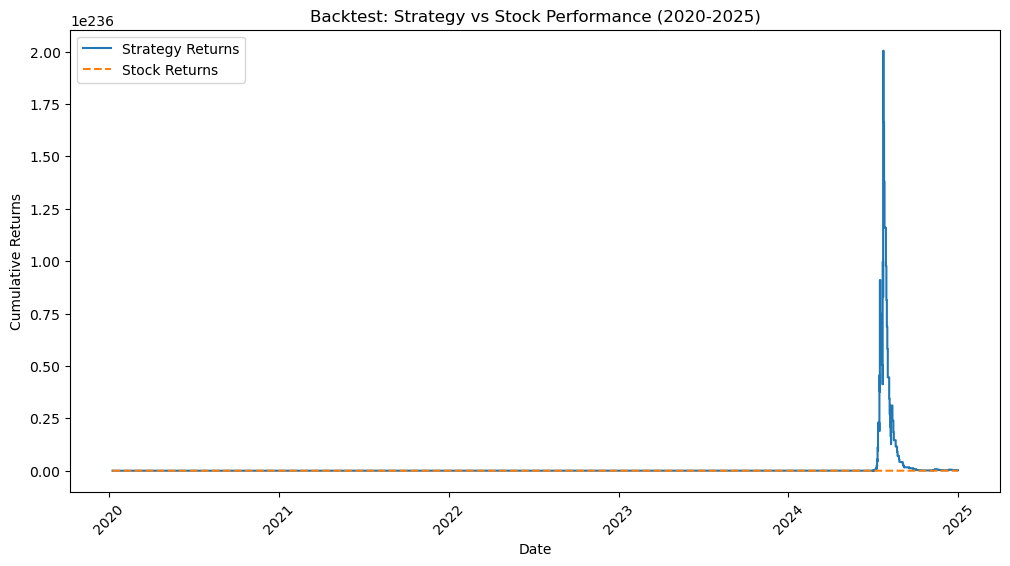

In [90]:
index_tuples = backtest_stocks.index.tolist()
dates = [item[0] for item in index_tuples]
tickers = [item[1] for item in index_tuples]

plt.figure(figsize=(12, 6))
plt.plot(dates, backtest_stocks['Cumulative_Strategy_Return'], label='Strategy Returns', linestyle='-')
plt.plot(dates, backtest_stocks['Cumulative_Stock_Return'], label='Stock Returns', linestyle='--')
plt.legend()
plt.title('Backtest: Strategy vs Stock Performance (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.xticks(rotation=45)
plt.show()